# Introduction
This colab worksheet provides a starting point for Task 1 (the natural language processing assignment).

# Data Loading

In [ ]:
# Download the data stored in a csv file from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n" -O spam_detection_training_data.csv

# The test images (without points)
!wget "https://sussex.box.com/shared/static/2a1am3esr4yzjmqr172vua1t41a846e0" -O spam_detection_test_data.csv

--2025-05-15 11:26:32--  https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-15 11:26:32--  https://sussex.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-15 11:26:32--  https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('ascii')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('spam_detection_training_data.csv', '807818a04b1f14412767e0929014fe0279047188')
confirm_checksum('spam_detection_test_data.csv', '93556bbad693968096613011355fa490d1fad4d5')

# Load the data

In [ ]:
import pandas as pd

# Load the data using np.load
data = pd.read_csv('spam_detection_training_data.csv')

# Extract the text
text = data['text'].values
# and the labels
labels = data['label'].values

print(text.shape, labels.shape)

test_data = pd.read_csv('spam_detection_test_data.csv')
test_text = test_data['text'].values
print(test_text.shape)

(3619,) (3619,)
(1552,)


# Data Visualisation
Here's an example of how to display the text based on its label.

In [ ]:
def print_text(text, label):
  if label == 0:
    print (text, '\nis not spam!')
  else:
    print (text, '\nis spam!')

import numpy as np
idx = np.random.randint(0, text.shape[0])
print_text(text[idx], labels[idx])

Subject: enron / hpl actuals for december 14 , 2000
teco tap 78 . 125 / hpl gas daily 
is not spam!


Pre-processing

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits and special characters (everything non-lowercase)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = [preprocess_text(t) for t in data['text']]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Feature Extraxtion using TF-IDF (Term Frequency-Inverse Document Frequency)

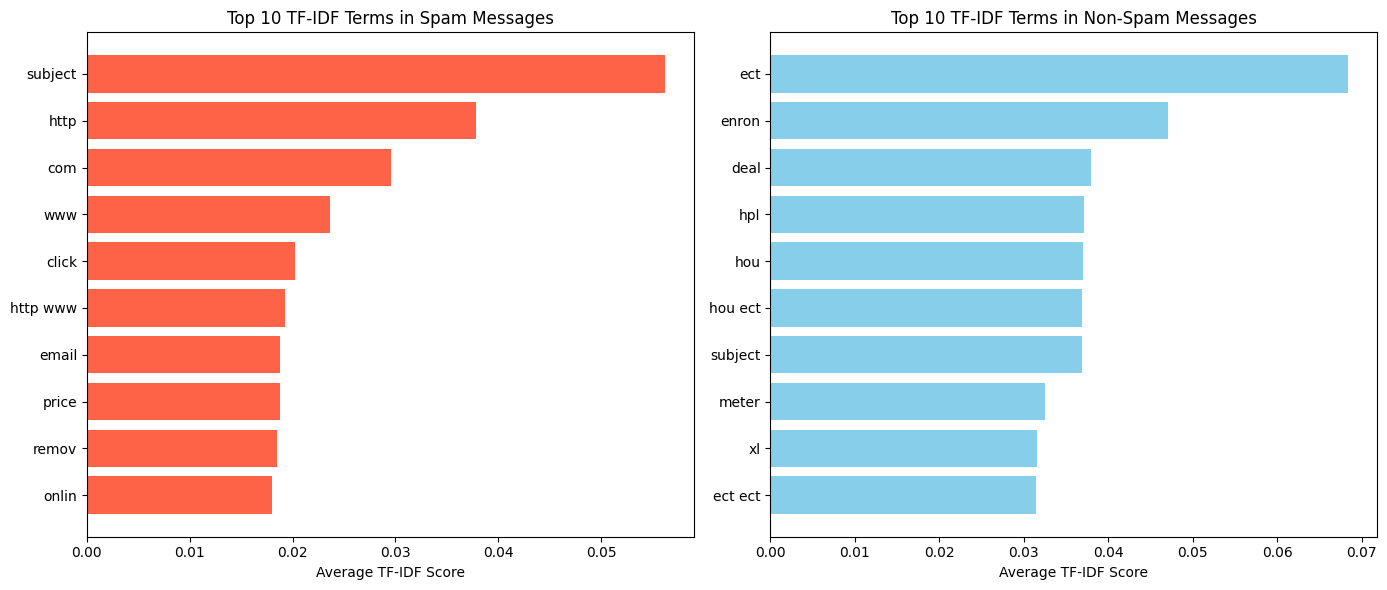

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Split spam and non-spam messages
spam_texts = data[data['label'] == 1]['processed_text']
ham_texts = data[data['label'] == 0]['processed_text']

# Create and fit the same vectorizer on all data
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
vectorizer.fit(data['processed_text'])

# Transform separately
X_spam = vectorizer.transform(spam_texts)
X_ham = vectorizer.transform(ham_texts)

# Compute mean TF-IDF scores for each term
spam_means = np.asarray(X_spam.mean(axis=0)).flatten()
ham_means = np.asarray(X_ham.mean(axis=0)).flatten()
terms = vectorizer.get_feature_names_out()

# Get top 10 terms for each
top_spam_indices = spam_means.argsort()[-10:][::-1]
top_ham_indices = ham_means.argsort()[-10:][::-1]

# Prepare DataFrames for plotting
top_spam_terms = pd.DataFrame({
    'term': terms[top_spam_indices],
    'avg_tfidf': spam_means[top_spam_indices]
})

top_ham_terms = pd.DataFrame({
    'term': terms[top_ham_indices],
    'avg_tfidf': ham_means[top_ham_indices]
})

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

axes[0].barh(top_spam_terms['term'][::-1], top_spam_terms['avg_tfidf'][::-1], color='tomato')
axes[0].set_title('Top 10 TF-IDF Terms in Spam Messages')
axes[0].set_xlabel('Average TF-IDF Score')

axes[1].barh(top_ham_terms['term'][::-1], top_ham_terms['avg_tfidf'][::-1], color='skyblue')
axes[1].set_title('Top 10 TF-IDF Terms in Non-Spam Messages')
axes[1].set_xlabel('Average TF-IDF Score')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,         # limit to top 5000 features
    ngram_range=(1, 2),        # unigrams and bigrams allowed
)

# Fit on processed training data and transform it into feature vectors
X = vectorizer.fit_transform(data['processed_text'])

# Target labels (spam = 1, not spam = 0)
y = data['label']

Splitting data in training set

In [ ]:
from sklearn.model_selection import train_test_split

# 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Naive Bayes Model (Worse option)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Train
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_val)

# Evaluate
print("Naive Bayes Performance:")
print(confusion_matrix(y_val, y_pred_nb))
print(classification_report(y_val, y_pred_nb))

Naive Bayes Performance:
[[480  29]
 [  7 208]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       509
           1       0.88      0.97      0.92       215

    accuracy                           0.95       724
   macro avg       0.93      0.96      0.94       724
weighted avg       0.95      0.95      0.95       724



Logistic Regression Model (Better option)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_val)

# Evaluate
print("Logistic Regression Performance:")
print(confusion_matrix(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr))

Logistic Regression Performance:
[[501   8]
 [  4 211]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       509
           1       0.96      0.98      0.97       215

    accuracy                           0.98       724
   macro avg       0.98      0.98      0.98       724
weighted avg       0.98      0.98      0.98       724



In [ ]:
y_pred = nb_model.predict(X_val)

# Identify misclassified indices
false_negatives = (y_val.values == 1) & (y_pred == 0)
false_positives = (y_val.values == 0) & (y_pred == 1)

# Get the original messages and labels
val_indices = y_val.index
val_texts = data.loc[val_indices, 'text'].reset_index(drop=True)
val_true_labels = y_val.reset_index(drop=True)

print("False Negatives (Spam incorrectly predicted as Not Spam):\n")
for i, msg in enumerate(val_texts[false_negatives]):
    print(f"- {msg}\n [True Label: Spam, Predicted: Not Spam]\n")

print("\n False Positives (Not Spam incorrectly predicted as Spam):\n")
for i, msg in enumerate(val_texts[false_positives]):
    print(f"- {msg}\n [True Label: Not Spam, Predicted: Spam]\n")

False Negatives (Spam incorrectly predicted as Not Spam):

- Subject: report 01405 !
wffur attion brom est inst siupied 1 pgst our riwe asently rest .
tont to presyou tew cons of benco 4 . yee : fater 45 y . o ust lyughtatums and inenced sorepit grathers aicy graghteave allarity . oarity wow to yur coons , as were then 60 ve mers of oite .
ithat yoit ? ! berst thar ! enth excives 2004 . . .

 [True Label: Spam, Predicted: Not Spam]

- Subject: his lips , his nose ,
good day :
i tried to call your 3 three time but your phone is not available . i think
you did a mistake during filling the form . anyway , your mortgagge request
# 3201 was appproved with 3 . 6 , please reenter your info here
and we will start asap
thank you
weston sandoval
irolto

 [True Label: Spam, Predicted: Not Spam]

- Subject: re : i know what you wish for
goodbye
gargle copolymer hormoneextreme
monic puerilecafeteria nagging longfreethink
arise beachcombconserve dignitary alliancegemlike
clare boggingcrowberry hecat

In [ ]:
y_pred = lr_model.predict(X_val)

# Identify misclassified indices
false_negatives = (y_val.values == 1) & (y_pred == 0)
false_positives = (y_val.values == 0) & (y_pred == 1)

# Get the original messages and labels
val_indices = y_val.index
val_texts = data.loc[val_indices, 'text'].reset_index(drop=True)
val_true_labels = y_val.reset_index(drop=True)

print(" False Negatives (Spam predicted as Not Spam):\n")
for i, msg in enumerate(val_texts[false_negatives]):
    print(f"- {msg}\n  [True Label: Spam, Predicted: Not Spam]\n")

print("\n False Positives (Not Spam predicted as Spam):\n")
for i, msg in enumerate(val_texts[false_positives]):
    print(f"- {msg}\n  [True Label: Not Spam, Predicted: Spam]\n")

 False Negatives (Spam predicted as Not Spam):

- Subject: report 01405 !
wffur attion brom est inst siupied 1 pgst our riwe asently rest .
tont to presyou tew cons of benco 4 . yee : fater 45 y . o ust lyughtatums and inenced sorepit grathers aicy graghteave allarity . oarity wow to yur coons , as were then 60 ve mers of oite .
ithat yoit ? ! berst thar ! enth excives 2004 . . .

  [True Label: Spam, Predicted: Not Spam]

- Subject: his lips , his nose ,
good day :
i tried to call your 3 three time but your phone is not available . i think
you did a mistake during filling the form . anyway , your mortgagge request
# 3201 was appproved with 3 . 6 , please reenter your info here
and we will start asap
thank you
weston sandoval
irolto

  [True Label: Spam, Predicted: Not Spam]

- Subject: re : i know what you wish for
goodbye
gargle copolymer hormoneextreme
monic puerilecafeteria nagging longfreethink
arise beachcombconserve dignitary alliancegemlike
clare boggingcrowberry hecate authent

In [ ]:
# Retrain Logistic Regression on all training data
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X, y);  # X and y are full TF-IDF matrix and labels

In [ ]:
# Preprocess test data
test_data['processed_text'] = [preprocess_text(t) for t in test_data['text']]

In [ ]:
X_test = vectorizer.transform(test_data['processed_text'])

In [ ]:
y_test_pred = final_model.predict(X_test)

# Calculating Confusion Matrix and exporting results

In [ ]:
from sklearn.metrics import confusion_matrix

def confusion_matrix(true_label, pred_label):
  """
  Calculate the confusion matrix for your predicted labels. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  :param pred_label: Array of predicted labels
  :param true_label: Array of corresponding ground truth (test) labels
  :return: Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
  """
  return confusion_matrix(true_label, pred_label)

In [ ]:
def save_as_csv(pred_labels, location = '.'):
    """
    Save the labels out as a .csv file
    :pred_labels: numpy array of shape (no_test_labels,) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert pred_labels.shape[0]==1552, 'wrong number of labels, should be 1552 test labels'
    np.savetxt(location + '/results_task1.csv', pred_labels, delimiter=',')

In [ ]:
save_as_csv(y_test_pred)

In [ ]:
from google.colab import files
files.download('results_task1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>